<a href="https://colab.research.google.com/github/UrielM21/IB/blob/main/Person_ReID_Market1501.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Market1501

In [1]:
!git clone https://github.com/Cysu/open-reid.git
!cd open-reid && python setup.py install
!mv open-reid openreid

!gdown --id 0B8-rUzbwVRk0c054eEozWG9COHM
!mkdir raw
!mv Market-1501-v15.09.15.zip raw/

Cloning into 'open-reid'...
remote: Enumerating objects: 1609, done.
remote: Total 1609 (delta 0), reused 0 (delta 0), pack-reused 1609
Receiving objects: 100% (1609/1609), 4.98 MiB | 33.13 MiB/s, done.
Resolving deltas: 100% (977/977), done.
running install
running bdist_egg
running egg_info
creating open_reid.egg-info
writing open_reid.egg-info/PKG-INFO
writing dependency_links to open_reid.egg-info/dependency_links.txt
writing requirements to open_reid.egg-info/requires.txt
writing top-level names to open_reid.egg-info/top_level.txt
writing manifest file 'open_reid.egg-info/SOURCES.txt'
writing manifest file 'open_reid.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/reid
copying reid/__init__.py -> build/lib/reid
copying reid/dist_metric.py -> build/lib/reid
copying reid/trainers.py -> build/lib/reid
copying reid/evaluators.py -> build/lib/reid
creating build/lib/r

In [4]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import io
import os
import numpy as np
import pandas as pd
import random
from functools import partial
from PIL import Image
from skimage.transform import resize
import json
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.experimental.AUTOTUNE
import sklearn as sk
from openreid.reid.datasets.market1501 import Market1501
# It needs to run twice...
data = Market1501(root='.', download=True)
data.load()

filenames_train =  [('images/' + x[0], str(x[1])) for x in data.train]
random.shuffle(filenames_train)

filenames_test =  [('images/' + x[0], str(x[1])) for x in data.val]
random.shuffle(filenames_test)

filenames_query =  [('images/' + x[0], str(x[1])) for x in data.query]
random.shuffle(filenames_query)

Using downloaded file: ./raw/Market-1501-v15.09.15.zip
Extracting zip file
Market1501 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   651 |    11189
  val      |   100 |     1747
  trainval |   751 |    12936
  query    |   750 |    16483
  gallery  |   751 |    19281
Market1501 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   526 |     8994
  val      |   225 |     3942
  trainval |   751 |    12936
  query    |   750 |    16483
  gallery  |   751 |    19281


In [6]:
class TripletDataset(tf.data.Dataset):

    def _generator(images_per_id, nr_of_ids):
        for i in range(nr_of_ids): 
          yield ([i] * images_per_id)
    
    def __new__(cls, datasets, images_per_id):
        nr_of_ids = len(datasets)
        choice_dataset = tf.data.Dataset.from_generator( 
            cls._generator, 
            (tf.int64), 
            (tf.TensorShape([None])),
            args=(images_per_id, nr_of_ids)
        ) \
        .shuffle(nr_of_ids) \
        .unbatch()

        return tf.data.experimental.choose_from_datasets(datasets, choice_dataset)

def process(data, img_height=224, img_width=224, pre_process=None):
  filename = data
  label = tf.strings.split(data, '/')[-1]
  label = tf.strings.split(label, '_')[0]
  label = tf.strings.to_number(label, out_type=tf.int32)
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  img = tf.cast(img, tf.float32)
  if pre_process is not None:
    img = pre_process(img)
  else:
    img /= 255.
  return img, label

def configure(ds, batch_size=128, img_size=(224, 224), pre_process=None):
  img_height, img_width = tuple(img_size)
  process_data = partial(process,
                         img_height=img_height,
                         img_width=img_width,
                         pre_process=pre_process)
  ds = ds.map(process_data, num_parallel_calls=AUTOTUNE)
  # ds = ds.cache() // Colab breaks...
  ds = ds.batch(batch_size)
  # ds = ds.shuffle(buffer_size=2048) # Shuffle AFTER the batch.
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def create_dataset(data, **kwargs):
  df = pd.DataFrame(data, columns=['File', 'Id'])
  sub_dfs = df.groupby('Id').apply(lambda x: x.File.to_list())

  ds_list = []
  for id_group in sub_dfs:
    if len(id_group) < 4:
      continue
    ds_list.append(tf.data.Dataset.from_tensor_slices(id_group))
  ds = TripletDataset(ds_list, 4)
  ds = configure(ds, **kwargs)
  return ds

def l2(a, b):
    # (a - b)^2 == a^2 - 2ab + b^2 
    # Es más eficiente, especialmente en cantidad de memoria.
    # Usar out en numpy evita la creacion de un array temporal y ahorra memoria.
    assert len(a.shape) == len(b.shape)
    a.astype(np.float32, copy=False)
    b.astype(np.float32, copy=False)
    aSum = np.empty(a.shape[0], dtype=np.float32)
    bSum = np.empty(b.shape[0], dtype=np.float32)
    mul = np.empty((a.shape[0], b.shape[0]), dtype=np.float32)
    aSum = np.sum(a**2, axis=-1, out=aSum) # shape = (N1,)
    bSum = np.sum(b**2, axis=-1, out=bSum) # shape = (N2,)
    np.dot(a, b.T, out=mul) # shape = (N1, N2)
    dists = aSum[:, np.newaxis] - 2 * mul + bSum  # shape = (N1, N2)
    return dists

def top1Acc(embeddings, labels):
  dist = l2(embeddings, embeddings)
  argsorted = np.argsort(dist, axis=1)
  predicted_labels = labels[argsorted[:, 1]] # 0: Query. 1: Vecino mas cercano
  predicted_labels = np.squeeze(predicted_labels)
  return np.mean(predicted_labels == np.squeeze(labels))
  
def images_to_sprite(data):
    """
    Source : https://github.com/tensorflow/tensorflow/issues/6322
    """
    if len(data.shape) == 3:
        data = np.tile(data[..., np.newaxis], (1, 1, 1, 3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) - min).transpose(3, 0, 1, 2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1, 2, 3, 0) / max).transpose(3, 0, 1, 2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    if n > 8192:
      print("Projector no acepta imagenes tan grandes!")
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
               (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
                  constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
                                                           + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

def normalize(x, scale=1, dtype=np.float32):
  return (scale*(x - x.min()) / (x.max() - x.min())).astype(dtype)

def prepare_for_visualization(embeddings, data_ds, name='test'):
  images = np.concatenate([x[0] for x in data_ds.as_numpy_iterator()]) # Podria usar .unbatch tambien
  images = normalize(images, scale=255, dtype=np.uint8)
  images = np.squeeze(images)
  images = resize(images, (images.shape[0], 64, 64, 3))

  labels = np.concatenate([x[1] for x in data_ds.as_numpy_iterator()])
  labels = [str(x) for x in labels]

  sprite_name = name+'_sprite.png'
  tensor_shape = list(embeddings.shape)
  single_image_dim = [images.shape[1], images.shape[2]]
  tensor_name = name+"_embeddings.bytes"
  metadataPath = name+'_meta.tsv'

  folder = 'oss_data/'
  try:
    os.mkdir(folder)
  except FileExistsError:
    pass
  out_m = io.open(os.path.join(folder, metadataPath), 'w', encoding='utf-8')
  # for img, labels in data_ds.as_numpy_iterator():
  #     [out_m.write(str(x) + "\n") for x in labels]
  for label in labels:
    out_m.write(label + "\n")
  out_m.close()

  sprite = Image.fromarray(images_to_sprite(images).astype(np.uint8))
  sprite.save(os.path.join(folder, sprite_name))
  print(name+': ', sprite.size)

  embeddings.tofile(os.path.join(folder, tensor_name))

  oss_json = {'embeddings':[]}
  json_to_append = {"tensorName": 'Visualization_'+name,
                    "tensorShape": tensor_shape,
                    "tensorPath": "oss_data/" + tensor_name,
                    "metadataPath": "oss_data/" + metadataPath,
                    "sprite": {"imagePath": "oss_data/" + sprite_name,
                                "singleImageDim": single_image_dim}}
  oss_json['embeddings'].append(json_to_append)
  with open(os.path.join(folder, name+'_projector_config.json'), 'w+') as f:
      json.dump(oss_json, f, ensure_ascii=False, indent=4)


# Create Dataset and Train model

In [ ]:
# Select Pre-Processing. It can be None.
pre_process = tf.keras.applications.mobilenet_v2.preprocess_input
# pre_process = tf.keras.applications.resnet_v2.preprocess_input

batch_size = 64

train_ds = create_dataset(filenames_train, img_size=(224, 224), batch_size=batch_size, pre_process=pre_process)
test_ds = create_dataset(filenames_test, img_size=(224, 224), batch_size=batch_size, pre_process=pre_process)
query_ds = create_dataset(filenames_query, img_size=(224, 224), batch_size=batch_size, pre_process=pre_process)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
            input_shape= (224, 224, 3),
            alpha=1.0,
            include_top=False,
            weights="imagenet",
            pooling='avg',
        )
# base_model = tf.keras.applications.ResNet50V2(
#               include_top=False,
#               weights="imagenet",
#               input_shape=(224, 224, 3),
#               pooling='avg',
#           )

input_img = tf.keras.Input(shape=(224, 224, 3))
x = base_model(input_img) # MobilenetV2: 1280; ResNet50V2: 2048;
output_emb = tf.keras.layers.Lambda(lambda embedding: tf.math.l2_normalize(embedding, axis=1))(x) # L2 normalize embeddings

model = tf.keras.Model(input_img, output_emb)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss=tfa.losses.TripletSemiHardLoss())

def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    return lr * tf.math.exp(-0.01)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
              './ckpts/modelCheckpoint',
              monitor="loss",
              save_best_only=True,),
              tf.keras.callbacks.LearningRateScheduler(scheduler)
            ]

# Train the network
history = model.fit(
    train_ds,
    epochs=200,
    callbacks=callbacks)

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/200
      2/Unknown - 0s 194ms/step - loss: 0.9738WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0920s vs `on_train_batch_end` time: 0.2965s). Check your callbacks.
     32/Unknown - 13s 392ms/step - loss: 0.9280INFO:tensorflow:Assets written to: ./ckpts/modelCheckpoint/assets
32/32 [==============================] - 35s 1s/step - loss: 0.9280
Epoch 2/200
32/32 [==============================] - 35s 1s/step - loss: 0.7636
Epoch 3/200
32/32 [==============================] - 35s 1s/step - loss: 0.5928
Epoch 4/200
32/32 [==============================] - 35s 1s/step - loss: 0.4843
Epoch 5/200
32/32 [==============================] - 35s 1s/step - loss: 0.3711
Epoch 6/200
32/32 [==============================] - 35s 1s/step - loss: 0.2870
Epoch 7/200
32/32 [==============================] - 35s 1s/step - loss: 0.2333
Epoch 8/200
32/32 [========================

# Save Model

In [ ]:
# model.save('models_MobileNetV2/')
# !zip -r models_MobileNetV2.zip models_MobileNetV2/

# model.save('models_ResNet50V2/')
# !zip -r models_ResNet50V2.zip models_ResNet50V2/

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'History_200_TL_MobileNetV2.json'
# hist_json_file = 'History_200_TL_ResNet50V2.json'

with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

INFO:tensorflow:Assets written to: models_MobileNetV2/assets
updating: models_MobileNetV2/ (stored 0%)
updating: models_MobileNetV2/variables/ (stored 0%)
updating: models_MobileNetV2/variables/variables.index (deflated 79%)
updating: models_MobileNetV2/variables/variables.data-00000-of-00001 (deflated 8%)
updating: models_MobileNetV2/assets/ (stored 0%)
updating: models_MobileNetV2/saved_model.pb (deflated 92%)


In [28]:
# !unzip models_MobileNetV2.zip
# model = tf.keras.models.load_model('models_MobileNetV2/')

# !unzip models_ResNet50V2.zip
# model = tf.keras.models.load_model('models_ResNet50V2/')

# Training Plot

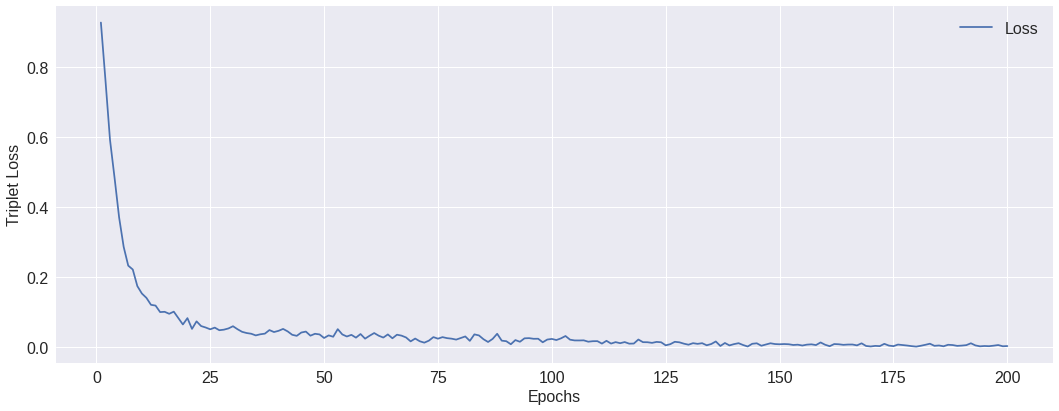

In [ ]:
fig, ax = plt.subplots(1, figsize=[15, 6])
ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Loss')
ax.set_xlabel("Epochs")
ax.set_ylabel("Triplet Loss")
ax.legend()

fig.tight_layout()
# fig.savefig('TripletLoss_MobilenetV2_train.pdf', bbox_inches='tight')
# fig.savefig('TripletLoss_ResNet50V2_train.pdf', bbox_inches='tight')

# Predict test set

In [8]:
# test_ds and query_ds have a shuffle inside, so I convert it back to
# Numpy so I can test the different models with the same test set order.
imgs_test = []
ids_test = []
for img, label in test_ds.unbatch().as_numpy_iterator():
  imgs_test.append(img)
  ids_test.append(int(label))
imgs_test = np.array(imgs_test)
ids_test = np.array(ids_test)

imgs_query = []
ids_query = []
for img, label in query_ds.unbatch().as_numpy_iterator():
  imgs_query.append(img)
  ids_query.append(int(label))
imgs_query = np.array(imgs_query)
ids_query = np.array(ids_query)

In [29]:
embeddings_train = model.predict(train_ds)
embeddings_test = model.predict(imgs_test, batch_size=batch_size)
embeddings_query = model.predict(imgs_query, batch_size=batch_size)

# Query Images

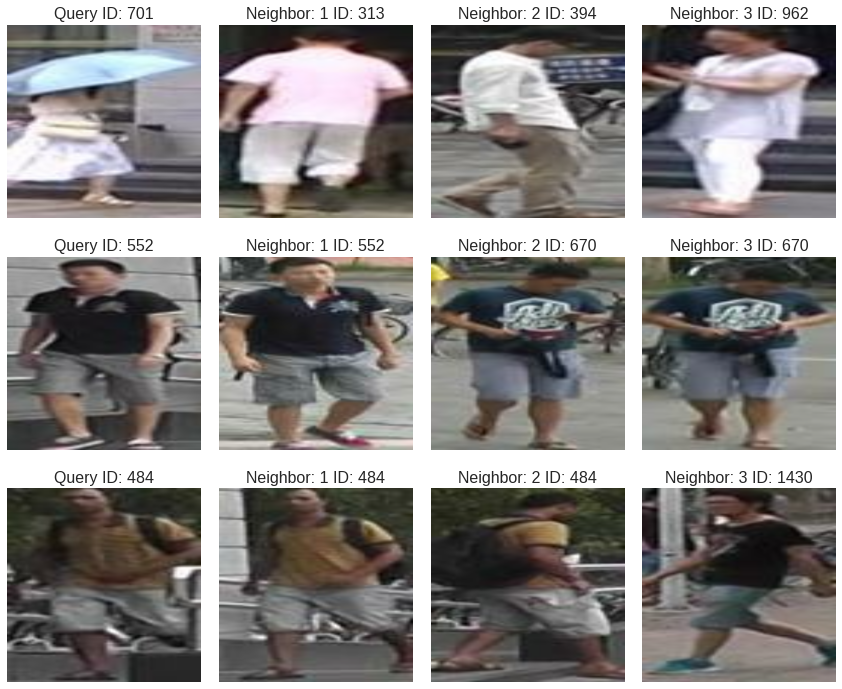

In [32]:
queries = [8, 12, 32] 
n = len(queries)
knn = 3

fig, ax = plt.subplots(n, knn+1, figsize=[12, 10])
for i, query in enumerate(queries):
  dist = l2(np.expand_dims(embeddings_test[query], 0), embeddings_test)
  argsorted = np.argsort(dist, axis=1)
  neighbors = argsorted[0, 1:knn+1]
  ax[i, 0].imshow(normalize(imgs_test[query]))
  ax[i, 0].set_title(f'Query ID: {ids_test[query]}')
  ax[i, 0].set_axis_off()
  for j, neig in enumerate(neighbors):
    ax[i, j+1].imshow(normalize(imgs_test[int(neig)])) 
    ax[i, j+1].set_title(f'Neighbor: {j+1} ID: {ids_test[int(neig)]}')   
    ax[i, j+1].set_axis_off()
fig.tight_layout()

# fig.savefig('Query_test_ResNet50V2.pdf', bbox_inches='tight')
# fig.savefig('Query_test_MobileNetV2.pdf', bbox_inches='tight')

# Top-1 Accuracy

In [31]:
top1Acc(embeddings_test, ids_test)

0.7363013698630136

# Prepare for Visualization

In [ ]:
# prepare_for_visualization(embeddings_train, train_ds, name='train')
prepare_for_visualization(embeddings_test, test_ds, name='test_MobileNetV2')

test_MobileNetV2:  (1920, 1920)
